In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

### Load Data

In [2]:
measurements = pd.read_csv(
    r"C:\Users\amali\python projects\ASHRAE global database of thermal comfort field measurements\db_measurements_v2.1.0.0.csv",
    low_memory=False,
    encoding="latin1"
)

metadata = pd.read_csv(
    r"C:\Users\amali\python projects\ASHRAE global database of thermal comfort field measurements\db_metadata_2.0.csv",
    encoding="latin1"
)

measurements.head()
metadata.head()


,building_id,building_id_inf,contributor,publication,region,country,city,lat,lon,climate,...,records,has_age,has_ec,has_timestamp,timezone,met_source,isd_station,isd_distance,database,quality_assurance
0,1,no,David Rowe,NaN,oceania,australia,sydney,-33.868820,151.209295,humid subtropical,...,170,no,no,yes,Australia/Sydney,rp884,947680-99999,2.3,1.0,pass
1,2,no,David Rowe,NaN,oceania,australia,sydney,-33.868820,151.209295,humid subtropical,...,83,no,no,yes,Australia/Sydney,rp884,947680-99999,2.3,1.0,pass
2,3,no,Fred Baumann,NaN,americas,usa,grand rapids,42.963360,-85.668086,humid midlatitude,...,85,no,no,yes,America/Detroit,rp884,726350-94860,14.9,1.0,pass
3,4,no,David Rowe,NaN,oceania,australia,sydney,-33.868820,151.209295,humid subtropical,...,137,no,no,yes,Australia/Sydney,NaN,947680-99999,2.3,1.0,pass
4,5,no,Gail Brager,"Benton, C. C. & Brager, G. S. Advanced Custome...",americas,usa,auburn,32.609857,-85.480783,mediterranean,...,128,no,no,yes,America/Chicago,rp884,722288-99999,2.1,1.0,pass


### Keep relevant columns

In [3]:
cols_map = {
    "ta": "ta",
    "tr": "tr",
    "rh": "rh",
    "vel": "vel",
    "met": "met",
    "clo": "clo",
    "thermal_sensation": "thermal_sensation",
    "timestamp": "timestamp",
    "season": "season",
    "building_id": "building_id",
    "gender": "gender",
    "age": "age"
}
existing = {k:v for k,v in cols_map.items() if v in measurements.columns}
meas = measurements[list(existing.values())].rename(columns={v:k for k,v in existing.items()})


### Merge with metadata

In [4]:
meta_use = metadata[["building_id","country","city","lat","lon","climate","building_type","cooling_type"]].copy()
merged = meas.merge(meta_use, on="building_id", how="left")

### Clean and transform

In [5]:
merged["timestamp"] = pd.to_datetime(merged["timestamp"], errors="coerce")
merged["month"] = merged["timestamp"].dt.month
merged["year"] = merged["timestamp"].dt.year

def age_group(x):
    try:
        x = float(x)
    except:
        return "unknown"
    if x < 18: return "<18"
    if x < 30: return "18–29"
    if x < 45: return "30–44"
    if x < 65: return "45–64"
    return "65+"

merged["age_group"] = merged["age"].apply(age_group)

### Create folder for saving images

In [6]:
output_dir = r"C:\Users\amali\python projects\ASHRAE global database of thermal comfort field measurements\visualizations"
os.makedirs(output_dir, exist_ok=True)

print("Files loaded successfully.")
print(f"Visualizations will be saved to: {output_dir}")

Files loaded successfully.
Visualizations will be saved to: C:\Users\amali\python projects\ASHRAE global database of thermal comfort field measurements\visualizations


### PLOT 1: Histogram of Thermal Sensation

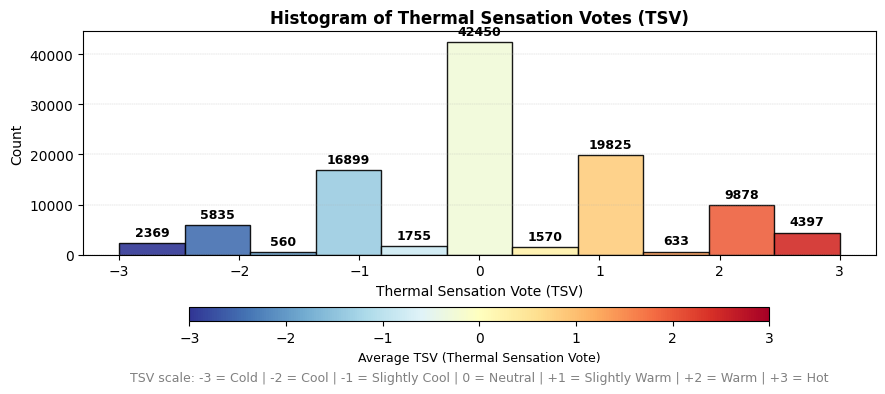

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# === Data Preparation ===
tsv = merged["thermal_sensation"].dropna().astype(float)

# === Histogram ===
fig, ax = plt.subplots(figsize=(9,5))
n, bins, patches = ax.hist(tsv, bins=11, edgecolor="black")

# === Color mapping: blue (cool) → neutral → orange (warm) ===
cmap = plt.colormaps.get_cmap("RdYlBu_r")
norm = mcolors.Normalize(vmin=-3, vmax=3)
for val, patch in zip(bins, patches):
    color = cmap(norm(val))
    patch.set_facecolor(color)
    patch.set_alpha(0.9)

# === Add count labels ===
for i in range(len(n)):
    ax.text(
        (bins[i] + bins[i+1]) / 2,
        n[i] + max(n)*0.02,
        f"{int(n[i])}",
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold"
    )

# === Titles and labels ===
ax.set_title("Histogram of Thermal Sensation Votes (TSV)", fontsize=12, weight="bold")
ax.set_xlabel("Thermal Sensation Vote (TSV)")
ax.set_ylabel("Count")

# === Colorbar (lowered slightly to avoid overlap) ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.18, aspect=40)
cbar.set_label("Average TSV (Thermal Sensation Vote)", fontsize=9)

# === Explanatory TSV scale (adjusted lower for spacing) ===
ax.text(
    0.5, -0.55,
    "TSV scale: -3 = Cold | -2 = Cool | -1 = Slightly Cool | 0 = Neutral | +1 = Slightly Warm | +2 = Warm | +3 = Hot",
    fontsize=9,
    color="gray",
    ha="center",
    va="center",
    transform=ax.transAxes
)

# === Styling ===
ax.grid(axis="y", linestyle="--", linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.22, top=0.8)
plt.savefig(os.path.join(output_dir, "hist_tsv_final_adjusted.png"))
plt.show()


### PLOT 2: TSV by Climate

C:\Users\amali\AppData\Local\Temp\ipykernel_15596\4049254424.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


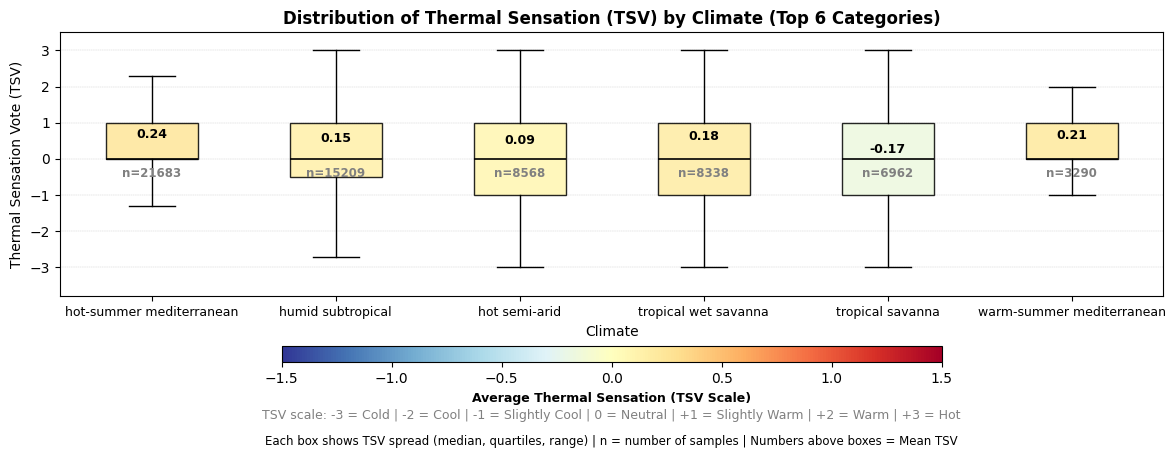

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# === Data Preparation ===
climate_counts = merged["climate"].value_counts().dropna()
top_climates = climate_counts.head(6).index.tolist()

data_for_box = [
    merged.loc[merged["climate"] == c, "thermal_sensation"].dropna().astype(float)
    for c in top_climates
]

# === Compute mean TSV for each climate (for color mapping) ===
climate_means = [
    merged.loc[merged["climate"] == c, "thermal_sensation"].mean() for c in top_climates
]

# === Color mapping (cool → warm gradient) ===
cmap = plt.colormaps.get_cmap("RdYlBu_r")
norm = mcolors.Normalize(vmin=-1.5, vmax=1.5)
colors = [cmap(norm(m)) for m in climate_means]

# === Create boxplot ===
fig, ax = plt.subplots(figsize=(12, 6))
box = ax.boxplot(
    data_for_box,
    patch_artist=True,
    labels=top_climates,
    showfliers=False,
)

# === Apply colors to each box ===
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)
    patch.set_edgecolor("black")

# === Highlight median lines for clarity ===
for median in box["medians"]:
    median.set(color="black", linewidth=1.2)

# === Add sample size (n) inside each box ===
for i, (climate, values) in enumerate(zip(top_climates, data_for_box)):
    n = len(values)
    y_pos = np.median(values) - 0.5  # position around median
    ax.text(i + 1, y_pos, f"n={n}", ha="center", fontsize=8.5, color="gray", weight="bold")

# === Add mean TSV label above each box ===
for i, m in enumerate(climate_means):
    ax.text(i + 1, m + 0.25, f"{m:.2f}", ha="center", va="bottom", fontsize=9, weight="bold")

# === Titles and Labels ===
ax.set_title(
    "Distribution of Thermal Sensation (TSV) by Climate (Top 6 Categories)",
    fontsize=12,
    weight="bold",
)
ax.set_ylabel("Thermal Sensation Vote (TSV)")
ax.set_xlabel("Climate")
ax.set_ylim(-3.8, 3.5)

# === Colorbar ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.15, aspect=40)
cbar.set_label("Average Thermal Sensation (TSV Scale)", fontsize=9, weight="bold")

# === Explanatory TSV scale text ===
ax.text(
    0.5, -0.45,
    "TSV scale: -3 = Cold | -2 = Cool | -1 = Slightly Cool | 0 = Neutral | +1 = Slightly Warm | +2 = Warm | +3 = Hot",
    fontsize=9,
    color="gray",
    ha="center",
    va="center",
    transform=ax.transAxes,
)

# === Small clarifying caption ===
ax.text(
    0.5, -0.55,
    "Each box shows TSV spread (median, quartiles, range) | n = number of samples | Numbers above boxes = Mean TSV",
    fontsize=8.5,
    color="black",
    ha="center",
    va="center",
    transform=ax.transAxes,
)

# === Styling ===
ax.set_xticklabels(top_climates, rotation=0, ha="center", fontsize=9)
ax.grid(axis="y", linestyle="--", linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.35, top=0.9)  # more space for bottom texts
plt.savefig(os.path.join(output_dir, "box_tsv_climate_enhanced.png"))
plt.show()


### PLOT 3: Air Temp vs TSV

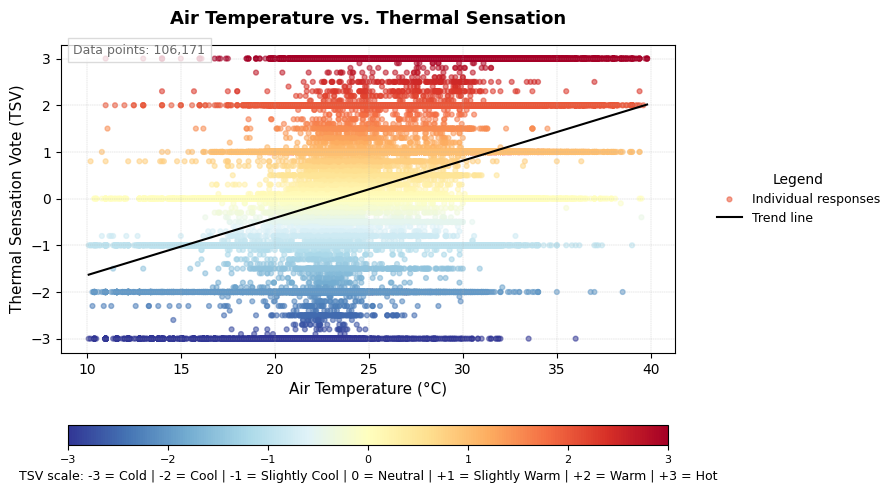

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# === Data Preparation ===
common = merged.dropna(subset=["ta", "thermal_sensation"])
x = common["ta"].astype(float)
y = common["thermal_sensation"].astype(float)

# === Color mapping for TSV ===
cmap = plt.colormaps.get_cmap("RdYlBu_r")
norm = mcolors.Normalize(vmin=-3, vmax=3)
colors = [cmap(norm(val)) for val in y]

# === Create figure and axis ===
fig, ax = plt.subplots(figsize=(8, 6))

# === Scatter plot with color scale ===
sc = ax.scatter(x, y, c=y, cmap=cmap, norm=norm, alpha=0.55, s=12, label="Individual responses")

# === Trend line ===
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(sorted(x), p(sorted(x)), color="black", linewidth=1.5, label="Trend line")

# === Titles and labels ===
ax.set_title("Air Temperature vs. Thermal Sensation", fontsize=13, fontweight="bold", pad=15)
ax.set_xlabel("Air Temperature (°C)", fontsize=11)
ax.set_ylabel("Thermal Sensation Vote (TSV)", fontsize=11)

# === Horizontal colorbar below plot ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.18, aspect=30)
cbar.set_label("TSV scale: -3 = Cold | -2 = Cool | -1 = Slightly Cool | 0 = Neutral | +1 = Slightly Warm | +2 = Warm | +3 = Hot", fontsize=9, labelpad=4)
cbar.ax.tick_params(labelsize=8)

# === Legend outside on the right ===
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    title="Legend",
    fontsize=9
)

# === Add data count label ===
ax.text(
    0.02, 0.97,
    f"Data points: {len(common):,}",
    fontsize=9,
    color="dimgray",
    transform=ax.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="lightgray")
)

# === Grid and layout adjustments ===
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.subplots_adjust(right=0.85, bottom=0.25)

# === Save & show ===
plt.savefig(os.path.join(output_dir, "scatter_ta_tsv_horizontal_scale.png"), dpi=300)
plt.show()


### PLOT 4: Average TSV by Building Type

<Figure size 1200x500 with 0 Axes>

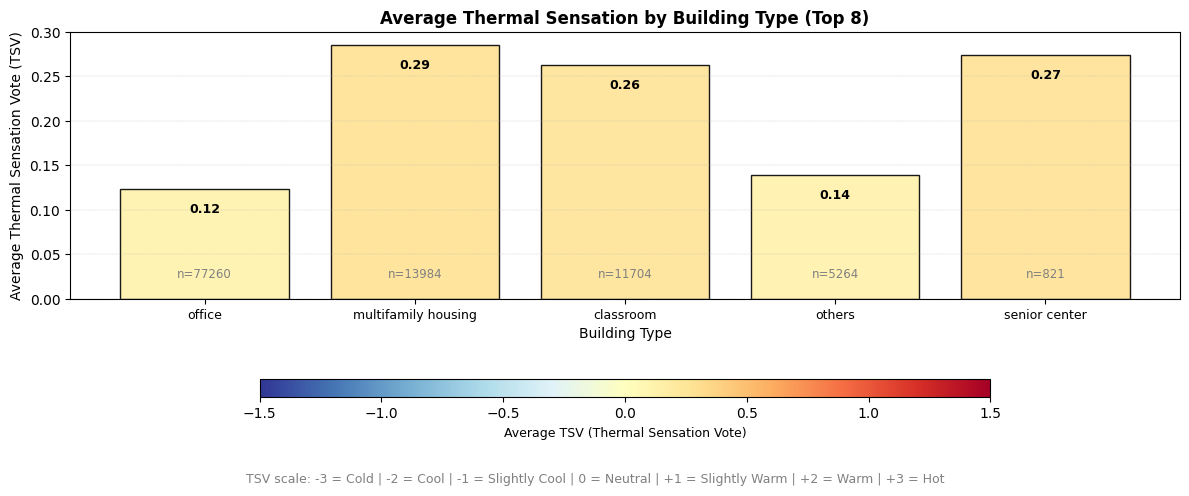

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.figure(figsize=(12,5))

# === Data Preparation ===
bt_counts = merged["building_type"].value_counts().dropna()
top_bt = bt_counts.head(8).index.tolist()

bt_means = (
    merged[merged["building_type"].isin(top_bt)]
    .groupby("building_type")["thermal_sensation"]
    .mean()
    .reindex(top_bt)
)
bt_counts_top = bt_counts.reindex(top_bt)

# === Color mapping: blue (cool) → neutral → orange (warm) ===
cmap = plt.colormaps.get_cmap("RdYlBu_r")
norm = mcolors.Normalize(vmin=-1.5, vmax=1.5)
colors = [cmap(norm(val)) for val in bt_means.values]

# === Create figure + axis explicitly ===
fig, ax = plt.subplots(figsize=(12,5))

# === Bar Plot ===
bars = ax.bar(bt_means.index.astype(str), bt_means.values, color=colors, edgecolor="black", alpha=0.9)

# === Add mean labels (inside bars to avoid title overlap) ===
for bar, mean in zip(bars, bt_means.values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        mean - 0.03,  # inside the bar
        f"{mean:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
        color="black"
    )

# === Add sample size labels (n=...) inside lower bar area ===
for bar, n in zip(bars, bt_counts_top.values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        0.02,  # near the base
        f"n={n}",
        ha="center",
        va="bottom",
        fontsize=8.5,
        color="gray"
    )

# === Add colorbar ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.22, aspect=40)
cbar.set_label("Average TSV (Thermal Sensation Vote)", fontsize=9)

# === Title & Labels ===
ax.set_title("Average Thermal Sensation by Building Type (Top 8)", fontsize=12, weight="bold")
ax.set_ylabel("Average Thermal Sensation Vote (TSV)")
ax.set_xlabel("Building Type")

# === TSV Scale Explanation (pushed lower to avoid overlap) ===
fig.text(
    0.5, 0.03,
    "TSV scale: -3 = Cold | -2 = Cool | -1 = Slightly Cool | 0 = Neutral | +1 = Slightly Warm | +2 = Warm | +3 = Hot",
    fontsize=9,
    color="gray",
    ha="center",
    va="center"
)

# === Layout Adjustments ===
ax.set_xticks(range(len(bt_means.index)))
ax.set_xticklabels(bt_means.index, rotation=0, ha="center", fontsize=9)
ax.grid(axis="y", linestyle="--", linewidth=0.3, alpha=0.7)
plt.tight_layout(rect=[0, 0.08, 1, 1])  # add bottom margin
plt.savefig(os.path.join(output_dir, "bar_tsv_building_type_fixed.png"), dpi=300, bbox_inches="tight")
plt.show()


### PLOT 5: TSV by Gender

C:\Users\amali\AppData\Local\Temp\ipykernel_15596\1056585465.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


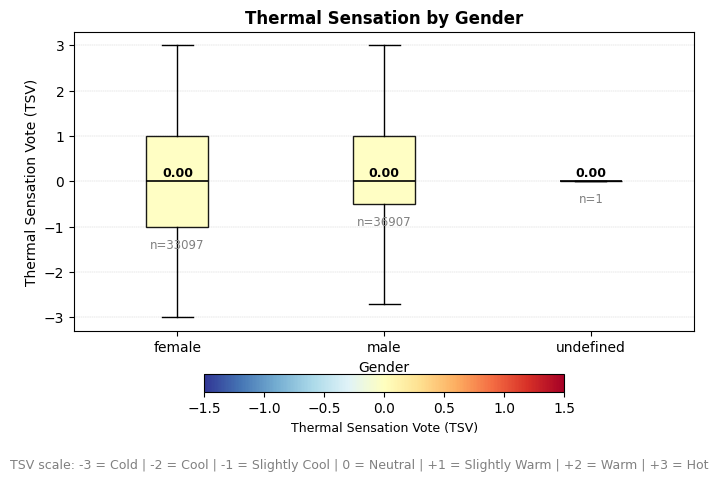

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors

# === Prepare Data ===
genders = merged["gender"].dropna().unique().tolist()
data_gender = [merged.loc[merged["gender"] == g, "thermal_sensation"].dropna().astype(float) for g in genders]
labels = [str(g) for g in genders]

# === Create Figure ===
fig, ax = plt.subplots(figsize=(7,5))

# === Color mapping (based on median TSV) ===
cmap = plt.colormaps.get_cmap("RdYlBu_r")
norm = mcolors.Normalize(vmin=-1.5, vmax=1.5)
medians = [np.median(vals) for vals in data_gender]
colors = [cmap(norm(m)) for m in medians]

# === Boxplot ===
box = ax.boxplot(
    data_gender,
    patch_artist=True,
    labels=labels,
    showfliers=False,
    medianprops=dict(color="black", linewidth=1.2)
)

# === Apply colors to boxes ===
for patch, color in zip(box['boxes'], colors):
    patch.set(facecolor=color, alpha=0.9, edgecolor="black")

# === Add median labels ===
for i, (vals, median) in enumerate(zip(data_gender, medians)):
    ax.text(
        i + 1,
        median + 0.05,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# === Add sample size (n=...) near each box ===
for i, vals in enumerate(data_gender):
    q1 = np.percentile(vals, 25)
    ax.text(
        i + 1,
        q1 - 0.25,  # slightly below the lower quartile
        f"n={len(vals)}",
        ha="center",
        va="top",
        fontsize=8.5,
        color="gray"
    )

# === Add colorbar for TSV scale ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.12)
cbar.set_label("Thermal Sensation Vote (TSV)", fontsize=9)

# === Titles and Labels ===
ax.set_title("Thermal Sensation by Gender", fontsize=12, weight="bold")
ax.set_ylabel("Thermal Sensation Vote (TSV)")
ax.set_xlabel("Gender")

# === Caption / Explanation (slightly higher) ===
fig.text(
    0.5, 0.06,
    "TSV scale: -3 = Cold | -2 = Cool | -1 = Slightly Cool | 0 = Neutral | +1 = Slightly Warm | +2 = Warm | +3 = Hot",
    fontsize=9,
    color="gray",
    ha="center",
    va="center"
)

# === Layout Adjustments ===
ax.grid(axis="y", linestyle="--", linewidth=0.3, alpha=0.7)
plt.tight_layout(rect=[0, 0.09, 1, 1])  # adjusted bottom for balance
plt.savefig(os.path.join(output_dir, "box_tsv_gender_styled_v2.png"), dpi=300, bbox_inches="tight")
plt.show()
